In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.tsa.stattools as stattools
import statsmodels.tsa.ardl as ardl
import math

import lead_lag as ll

In [2]:
df = pd.read_csv("../prices.txt", sep='\s+', header=None, index_col=None)
df.describe()

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.00000,500.000000,500.000000,...,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,13.845620,69.033740,47.262580,48.004780,55.496120,11.740700,18.177200,46.78280,68.537300,50.185100,...,31.651400,63.251640,12.502360,60.843540,36.523580,52.461460,57.537160,34.427360,41.273040,56.123620
std,0.748745,3.908187,0.614438,2.051494,1.733916,0.635884,0.299771,1.26656,0.585843,3.207362,...,0.771223,7.833634,0.940225,1.898022,1.561982,0.756214,4.548284,0.878169,3.814908,1.178059
min,12.630000,62.470000,46.330000,44.900000,51.660000,10.020000,17.650000,44.01000,67.260000,45.260000,...,30.270000,50.620000,10.630000,56.260000,31.760000,50.210000,49.200000,32.800000,31.640000,53.470000
25%,13.207500,65.517500,46.820000,45.750000,54.000000,11.480000,17.970000,45.91750,68.110000,47.597500,...,30.950000,55.865000,11.817500,59.420000,35.837500,52.050000,54.062500,33.800000,39.615000,55.317500
50%,13.590000,68.255000,46.975000,47.830000,55.880000,11.850000,18.100000,46.69000,68.550000,49.535000,...,31.590000,64.615000,12.210000,60.750000,36.825000,52.375000,55.425000,34.350000,41.665000,56.100000
75%,14.582500,72.915000,47.800000,50.380000,56.720000,12.210000,18.410000,47.50250,68.912500,52.192500,...,32.302500,70.352500,13.232500,62.107500,37.602500,52.892500,61.855000,35.032500,43.525000,57.002500
max,15.560000,75.150000,48.610000,51.010000,59.120000,13.000000,18.980000,51.09000,69.990000,59.100000,...,33.260000,77.470000,14.500000,66.090000,39.130000,54.150000,66.600000,36.480000,50.020000,59.310000


In [4]:
# Check if stationary
# Non-stationary
def test_stationary(series):
    print("Results of Dickey-Fuller Test:")
    dftest = stattools.adfuller(series, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)

    print("Results of KPSS Test:")
    kpsstest = stattools.kpss(series, regression="c", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)

test_stationary(df[8])

Results of Dickey-Fuller Test:
Test Statistic                  -2.613868
p-value                          0.090165
#Lags Used                       2.000000
Number of Observations Used    497.000000
Critical Value (1%)             -3.443576
Critical Value (5%)             -2.867373
Critical Value (10%)            -2.569877
dtype: float64
Results of KPSS Test:
Test Statistic            0.665248
p-value                   0.016705
Lags Used                12.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


In [5]:
# Best order for ARIMA: (2, 1, 1)
model8 = sm.tsa.arima.ARIMA(endog=(df[8] - df[8].mean()), order=(2, 1, 1))
res8 = model8.fit()
print(res8.summary())

res8.save("../model8.pickle")

                               SARIMAX Results                                
Dep. Variable:                      8   No. Observations:                  500
Model:                 ARIMA(2, 1, 1)   Log Likelihood                 447.039
Date:                Fri, 28 Jun 2024   AIC                           -886.078
Time:                        20:53:51   BIC                           -869.228
Sample:                             0   HQIC                          -879.466
                                - 500                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6735      0.145     -4.638      0.000      -0.958      -0.389
ar.L2          0.1572      0.048      3.294      0.001       0.064       0.251
ma.L1          0.7773      0.142      5.466      0.0

In [ ]:
res8 = sm.load("../arima_model/model8.pickle")
applied8 = res8.apply(df[8][1:111] - df[8].mean())
print(applied8.forecast(1).values[1] + df[8].mean(), df[8][111])

67.85658536284753 67.69


In [6]:
print(res8.resid)
print(res8.resid[1:].mean())
print(res8.resid[1:].std())
print(res8.resid[1:].max())

0      0.952700
1      0.240000
2     -0.153814
3     -0.067659
4      0.172100
         ...   
495    0.061481
496    0.034413
497   -0.105526
498    0.095125
499    0.024082
Length: 500, dtype: float64
-0.0007179878632538049
0.09889691523636979
0.33614225197037406


In [7]:
test_stationary(res8.resid)

Results of Dickey-Fuller Test:
Test Statistic                 -23.405139
p-value                          0.000000
#Lags Used                       0.000000
Number of Observations Used    499.000000
Critical Value (1%)             -3.443523
Critical Value (5%)             -2.867350
Critical Value (10%)            -2.569864
dtype: float64
Results of KPSS Test:
Test Statistic           0.043741
p-value                  0.100000
Lags Used                1.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64


C:\Users\DELL\AppData\Local\Temp\ipykernel_19464\61105336.py:20: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpsstest = stattools.kpss(series, regression="c", nlags="auto")


In [8]:
print(df[8])
priceChange = np.array(df[8])[1:] - np.array(df[8])[:-1]

print(priceChange)
print(priceChange.mean())

print(priceChange.std())

0      69.49
1      69.73
2      69.60
3      69.54
4      69.68
       ...  
495    69.00
496    69.04
497    68.95
498    69.03
499    69.06
Name: 8, Length: 500, dtype: float64
[ 0.24 -0.13 -0.06  0.14  0.13 -0.05  0.   -0.12 -0.11 -0.12 -0.04  0.01
 -0.19 -0.1  -0.03 -0.12 -0.06 -0.15 -0.18 -0.01  0.15  0.09 -0.03  0.02
  0.01  0.1   0.05 -0.2  -0.09  0.08  0.13  0.12 -0.07  0.    0.    0.02
 -0.04 -0.15 -0.04  0.08  0.05 -0.07 -0.11 -0.08  0.04  0.02 -0.08  0.18
 -0.21  0.11  0.06  0.17  0.06 -0.01 -0.05 -0.04 -0.07 -0.06  0.01  0.02
  0.07  0.12 -0.04 -0.13  0.03 -0.12  0.06 -0.06 -0.15 -0.07 -0.04 -0.05
 -0.04  0.04 -0.01 -0.07 -0.06  0.03 -0.03  0.02 -0.1  -0.14 -0.06  0.12
  0.17  0.11 -0.11  0.08 -0.02  0.07 -0.18  0.09 -0.01 -0.05 -0.03 -0.09
  0.07 -0.18 -0.07 -0.19 -0.18 -0.01  0.04 -0.1  -0.14  0.03  0.19  0.07
  0.23  0.06  0.02  0.2   0.01 -0.04 -0.04  0.16 -0.07 -0.02  0.04  0.09
  0.12 -0.03  0.07  0.08 -0.04  0.03  0.02 -0.17 -0.07  0.04 -0.03  0.07
  0.07  0.13  0.1

0.9069515239547417


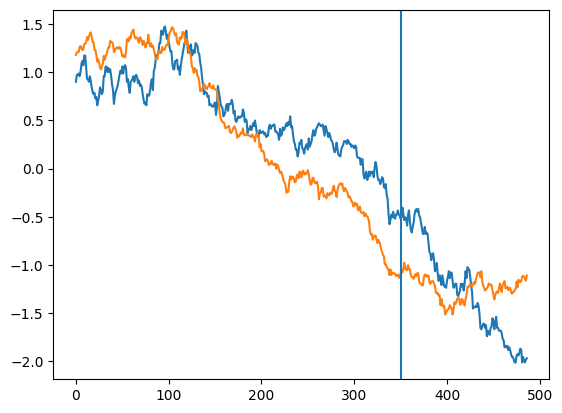

In [9]:
# Check for lead lags
share1 = 18
share2 = 3
lag = 13

standard1 = (df[share1] - df[share1].mean())/ df[share1].std()
standard2 = (df[share2] - df[share2].mean())/ df[share2].std()
shifted1 = pd.Series(np.array(standard1)[:-lag])
shifted2 = pd.Series(np.array(standard2)[lag:])

print(shifted1.corr(shifted2))

sns.lineplot(shifted1)
sns.lineplot(shifted2)
plt.axvline(350)


In [24]:
# Predict function for lead lag
def predict(df, ticker, indices, lags, currentPoint):
    if len(indices) > 1:
        matchedSeries = df[indices].pct_change().dropna().values[currentPoint-200:currentPoint+1, :]
    else:
        matchedSeries = df[indices].pct_change().dropna().values[currentPoint-200:currentPoint+1]

    result = ardl.ARDL(
        df[ticker].pct_change().dropna().values[currentPoint-200:currentPoint+1],
        0,
        matchedSeries,
        lags,
        causal=True
    ).fit()

    predict_mu = result.forecast()
    # print(predict_mu)
    return predict_mu

-0.0001610862776782848 0.001017401358200219
3.0994176719732626e-05 0.001135093952787679


<Axes: >

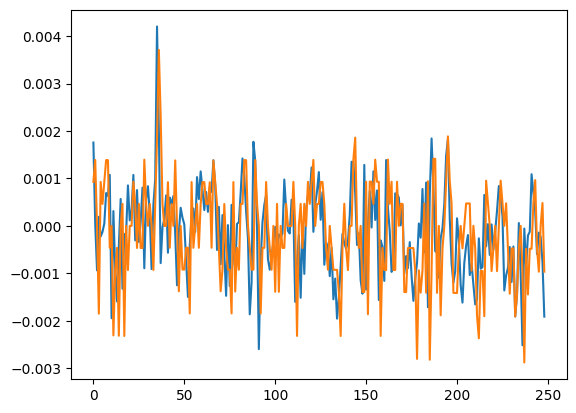

In [26]:
predictValues = []
errors = []
actuals = []

sharePredict = 38
indices = list(range(50))
for i in range(250, 499):
    predict_mu = predict(df, sharePredict, indices, 1, i)[-1]
    actual_mu = ((df[sharePredict][i + 1] - df[sharePredict][i])/df[sharePredict][i])
    error = predict_mu - actual_mu
    errors.append(error)
    actuals.append(actual_mu)
    predictValues.append(predict_mu)

actuals = pd.Series(actuals)
errors = pd.Series(errors)
print(actuals.mean(), actuals.std())
print(errors.mean(), errors.std())

sns.lineplot(predictValues)
sns.lineplot(actuals)